## Oil Price Analysis

### Training LSTM model

#### Importing necessary libraries

In [121]:
import os
import sys
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, LSTM, Dense, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping 
from tensorflow.keras.metrics import RootMeanSquaredError,MeanAbsoluteError
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


import tensorflow as tf
import yaml

sns.set_theme('notebook')

In [ ]:
parent_dir = os.path.dirname(os.getcwd())
os.chdir(parent_dir)
sys.path.append(parent_dir)

In [156]:
with open("params.yaml") as conf_file:
    config = yaml.safe_load(conf_file)

print(config)

{'base': {'random_state': 42, 'verbose': 1, 'batch_size': 32, 'epochs': 10}, 'data': {'dataset_csv': 'data/BrentOilPrices.csv', 'test_size': 60, 'time_steps': 30}, 'model': {'layers': [{'name': 'InputLayer', 'shape': [30, 1]}, {'name': 'LSTM', 'units': 64, 'activation': 'tanh', 'return_sequences': False}, {'name': 'Dense', 'units': 8, 'activation': 'relu'}, {'name': 'OutputLayer', 'units': 1, 'activation': 'linear'}]}, 'training': {'loss': 'MeanSquaredError', 'optimizer': 'Adam', 'learning_rate': 0.01, 'metrics': ['MeanAbsoluteError', 'MeanSquaredError', 'RootMeanSquaredError'], 'early_stopping': {'monitor': 'val_loss', 'patience': 3, 'mode': 'min'}, 'model_path': 'models/model.joblib'}, 'output': {'report_dir': 'reports', 'model_dir': 'models'}, 'report': {'model_path': 'models/LSTM.keras', 'metircs_file': 'reports/metrics.json', 'metrics_loss': 'reports/loss.png', 'metrics_mse': 'reports/mean_squared_error.png', 'metrics_mae': 'reports/mean_absolute_error.png', 'metrics_rmse': 'repor

In [154]:
if not os.path.exists(config['output']['report_dir']):
    os.makedirs(config['output']['report_dir'])

if not os.path.exists(config['output']['model_dir']):
    os.makedirs(config['output']['model_dir'])

### Load Dataset

In [ ]:
data = pd.read_csv(config['data']['dataset_csv'], index_col='Date')
data.head()

,Price
Date,
20-May-87,18.63
21-May-87,18.45
22-May-87,18.55
25-May-87,18.60
26-May-87,18.63


In [ ]:

def create_sequence(data, time_steps = config['data']['time_steps']):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

In [113]:

def train_test_split(data, test_size = config['data']['test_size']):
    train = data[:-test_size]
    test = data[-test_size:]

    return train, test

In [114]:
train, test = train_test_split(data)

### Feature Engineering 

In [47]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train.values.reshape(-1, 1))
test_scaled = scaler.transform(test.values.reshape(-1, 1))

In [115]:

X_train, y_train = create_sequence(train_scaled)
X_test, y_test = create_sequence(test_scaled)

### Model Training

In [150]:
callback = EarlyStopping(
    monitor=config['training']['early_stopping']['monitor'],
    patience=config['training']['early_stopping']['patience'],
    mode=config['training']['early_stopping']['mode']
)

model = Sequential()
for layer_config in config['model']['layers']:
    if layer_config['name'] == 'InputLayer':
        model.add(InputLayer(input_shape=layer_config['shape']))
    elif layer_config['name'] == 'LSTM':
        model.add(LSTM(units=layer_config['units'], activation=layer_config['activation'], return_sequences=layer_config['return_sequences']))
    elif layer_config['name'] == 'Dense':
        model.add(Dense(units=layer_config['units'], activation=layer_config['activation']))
    elif layer_config['name'] == 'OutputLayer':
        model.add(Dense(units=layer_config['units'], activation=layer_config['activation']))


model.compile(
    loss=eval(config['training']['loss'])(),
    optimizer=Adam(learning_rate=config['training']['learning_rate']),
    metrics=[eval(metric)() for metric in config['training']['metrics']]
)

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                epochs=config['base']['epochs'], callbacks=[ callback],
                batch_size = config['base']['batch_size'], verbose=config['base']['verbose'])

Epoch 1/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 2.8518e-04 - mean_absolute_error: 0.0111 - mean_squared_error: 2.8518e-04 - root_mean_squared_error: 0.0169 - val_loss: 8.7485e-04 - val_mean_absolute_error: 0.0247 - val_mean_squared_error: 8.7485e-04 - val_root_mean_squared_error: 0.0296
Epoch 2/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 2.2281e-04 - mean_absolute_error: 0.0100 - mean_squared_error: 2.2281e-04 - root_mean_squared_error: 0.0149 - val_loss: 5.2079e-04 - val_mean_absolute_error: 0.0182 - val_mean_squared_error: 5.2079e-04 - val_root_mean_squared_error: 0.0228
Epoch 3/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 1.8939e-04 - mean_absolute_error: 0.0094 - mean_squared_error: 1.8939e-04 - root_mean_squared_error: 0.0138 - val_loss: 3.5309e-04 - val_mean_absolute_error: 0.0157 - val_mean_squared_error: 3.5309e-04 - val_root_mean_squared_error: 0.0188
Epoch 4/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 1.6969e-04 - mean_absolute_error: 0.

In [155]:
model.save(filepath=config['report']['model_path'])

### Model evaluating

In [54]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

forecast = model.predict(X_test)
actual_values = y_test

# Mean Absolute Error (MAE)
mae = mean_absolute_error(actual_values, forecast)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(actual_values, forecast))

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((actual_values - forecast) / actual_values)) * 100

# Print the results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%") 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
Mean Absolute Error (MAE): 0.011807512092496041
Root Mean Squared Error (RMSE): 0.014757275226589501
Mean Absolute Percentage Error (MAPE): 1.8649556757576002%


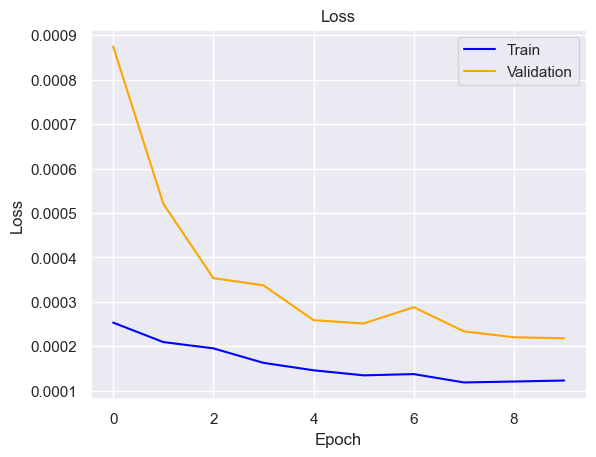

In [ ]:
sns.lineplot(data=history.history['loss'], label='Train', color='blue')
sns.lineplot(data=history.history['val_loss'], label='Validation', color='orange')

plt.title("Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
loss = plt.gcf()

loss.savefig(config['report']['metrics_loss'])

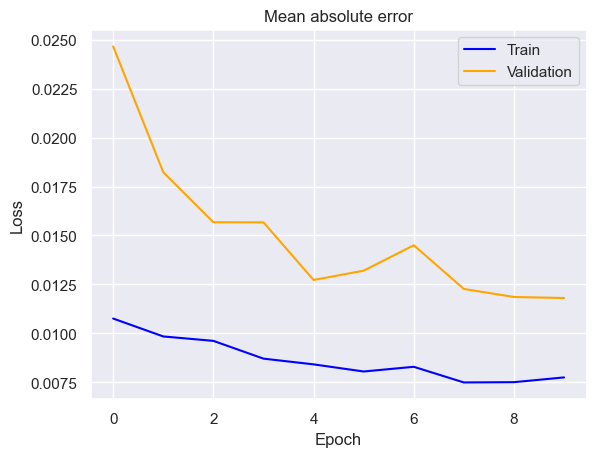

In [ ]:
sns.lineplot(data=history.history['mean_absolute_error'], label='Train', color='blue')
sns.lineplot(data=history.history['val_mean_absolute_error'], label='Validation', color='orange')

plt.title('Mean absolute error')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
mean_absolute_error = plt.gcf()

mean_absolute_error.savefig(config['report']['metrics_mae'])

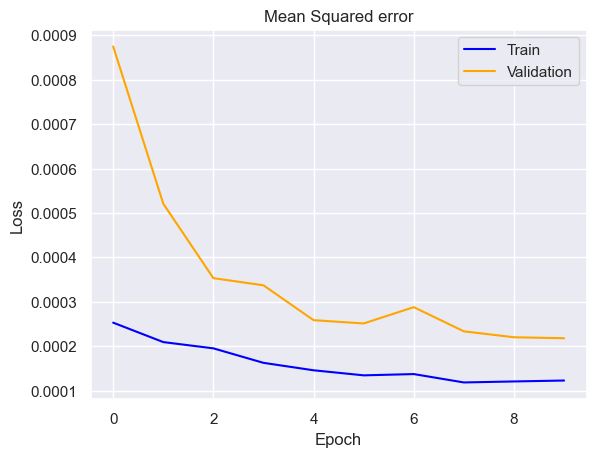

In [140]:
sns.lineplot(data=history.history['mean_squared_error'], label='Train', color='blue')
sns.lineplot(data=history.history['val_mean_squared_error'], label='Validation', color='orange')

plt.title("Mean Squared error")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
mean_squared_error = plt.gcf()

mean_squared_error.savefig(config['report']['metrics_mse'])

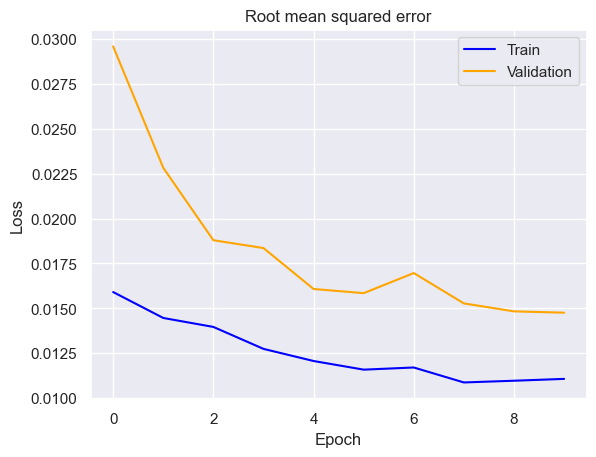

In [ ]:
sns.lineplot(data=history.history['root_mean_squared_error'], label='Train', color='blue')
sns.lineplot(data=history.history['val_root_mean_squared_error'], label='Validation', color='orange')

plt.title("Root mean squared error")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
root_mean_squared_error = plt.gcf()

root_mean_squared_error.savefig(config['report']['metrics_rmse'])